# Set-up

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Functions

In [59]:
# Teste ADF -  Augmented Dickey-Fuller (Teste para verificar se a série é estacionária)
def teste_estacionaridade(df, sig=0.05):
  adf_result = adfuller(df)
  significancia = sig
  h0 = "H0: A série não é estacionária."
  h1 = "H1: A série é estacionária."

  print("Teste ADF:")
  print(h0)
  print(h1)
  print("\n")
  print(f"Teste estatístico: {adf_result[0]}")
  print(f"p-value: {adf_result[1]}")
  print(f"Valores críticos: {adf_result[4]}")

  if adf_result[1] > significancia:
    print("Não existe evidência estatística suficiente para rejeitar H0.")
  else:
    print("Existe evidência estatística suficiente para rejeitar H0.")


def plot_decompose_serie(df, period):
    # Plotando a série a suas decomposições
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(16, 20))

    decompose_results = seasonal_decompose(x=df, period=period)

    decompose_results.observed.plot(ax=ax1)
    # df_fechamento['2020-01-01':'2020-12-31'].rename(columns={'Último':'ano 2020'}).plot(ax=ax1, color='red')
    ax1.set_title("Série temporal")

    decompose_results.trend.plot(ax=ax2)
    ax2.set_title("Tendência", loc='left')

    decompose_results.seasonal.plot(ax=ax3)
    ax3.set_title("Sazonalidade")

    decompose_results.resid.plot(ax=ax4)
    ax4.set_title("Resíduo")

    plt.show()


def joinTestPred(df_test, df_pred):
  # Extrair as colunas relevantes dos DataFrames
  previsao_cols = ['ds', 'yhat']
  valores_reais_cols = ['ds', 'y']

  previsao = df_pred[previsao_cols]
  valores_reais = df_test[valores_reais_cols]

  # Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
  resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

  return resultados


# Função com o calculo de weighted MAPE
def wmape(y_true, y_pred):
  return np.abs(y_pred - y_true).sum() / np.abs(y_true).sum()


# Função para calcular métricas de avaliação
def evaluation_ts(model_name, y_true, y_pred):
  wmape_value = wmape(y_true=y_true, y_pred=y_pred)
  mape = mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)
  mae = mean_absolute_error(y_true=y_true, y_pred=y_pred)
  mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
  rmse = mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False)

  # print("Métricas de avaliação: \n")
  # print("WMAPE:", wmape_value)
  # print("MAPE:", mape)
  # print("MAE:", mae)
  # print("MSE:", mse)
  # print("RMSE:", rmse)

  return pd.DataFrame.from_dict(
      {
          'model':[model_name],
          'wmape':[wmape_value],
          'mape':[mape],
          'mae':[mae],
          'mse':[mse],
          'rmse':[rmse]
      }
)

In [25]:
df = pd.read_csv('ipea.csv', sep=';')

# Pre-processing

In [26]:
df['date'] = pd.to_datetime(df['date'])

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11164 entries, 0 to 11163
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    11164 non-null  datetime64[ns]
 1   price   11164 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 174.6 KB


# Building model

# Analysis 

In [28]:
price_df = df.rename(columns={'date':'ds', 'price':'y'}).set_index('ds')

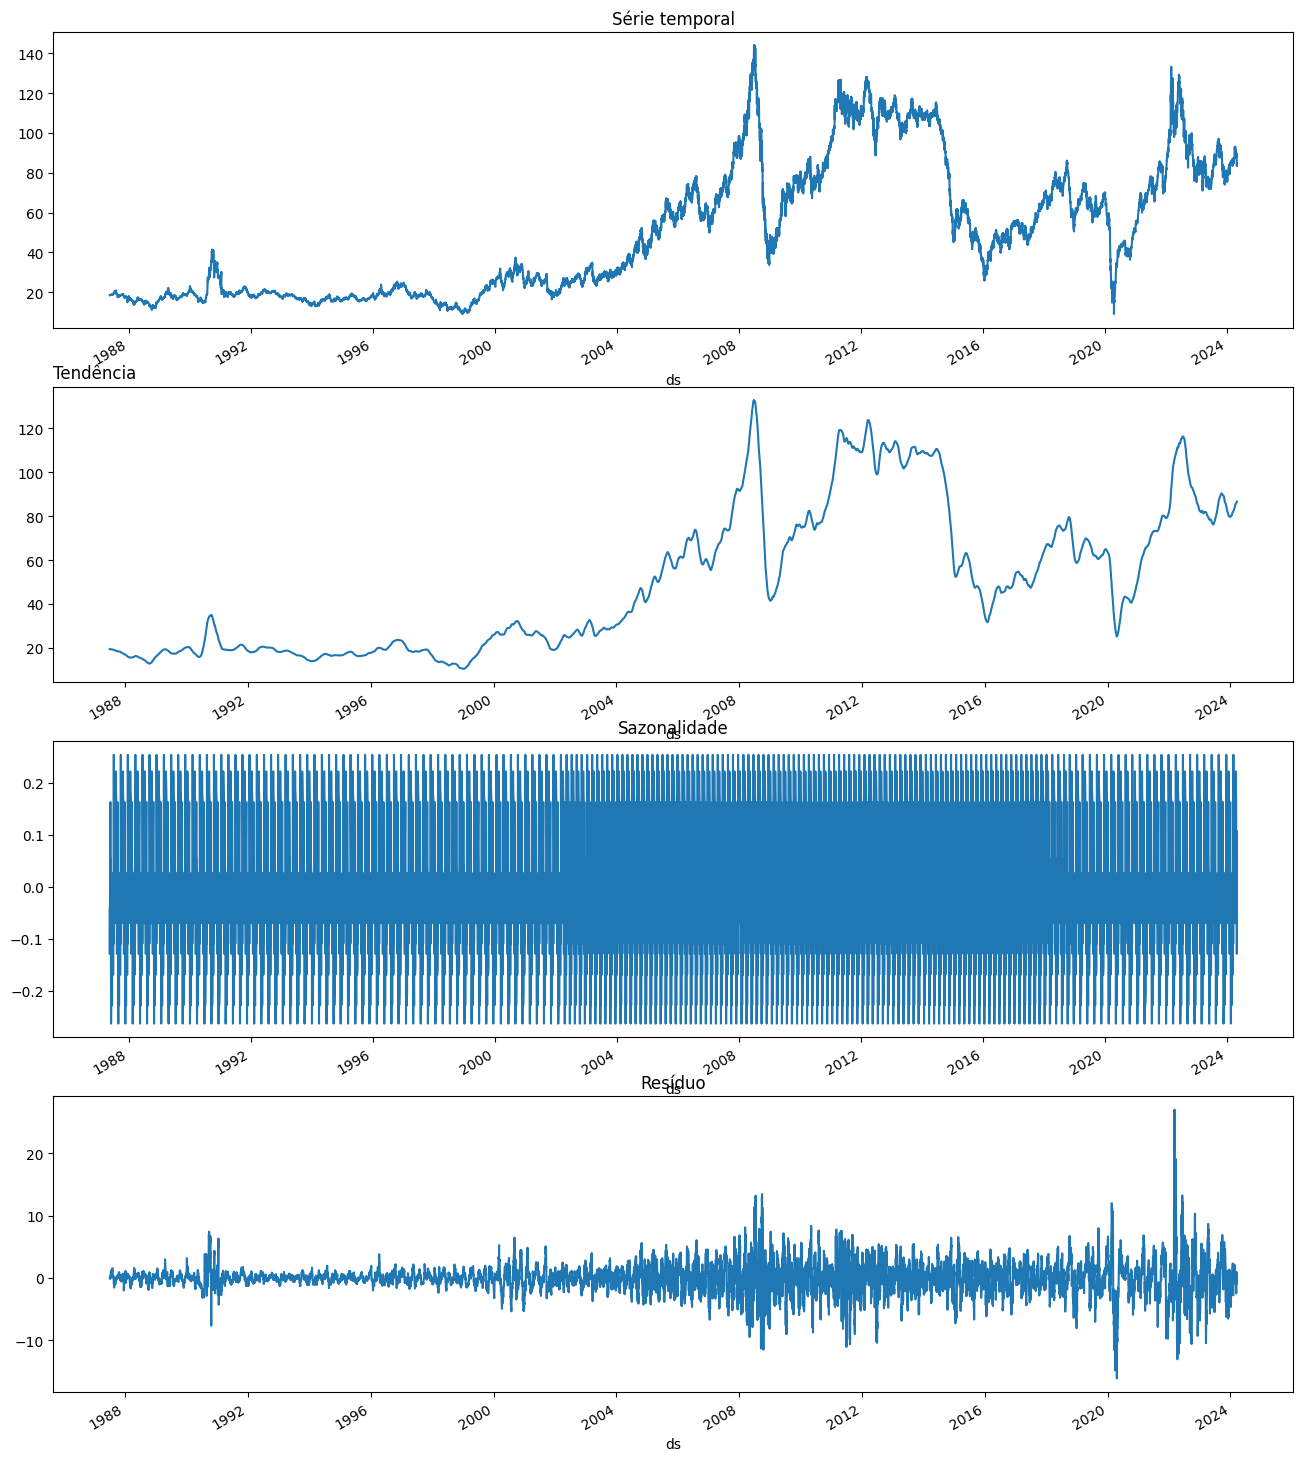

In [29]:
plot_decompose_serie(df=price_df, period=60)

## Split train and test

In [30]:
price_df.reset_index()['ds'].dt.day_name().value_counts(dropna=False, normalize=True)

ds
Wednesday    0.170996
Thursday     0.170727
Tuesday      0.170727
Friday       0.169473
Monday       0.166070
Saturday     0.078466
Sunday       0.073540
Name: proportion, dtype: float64

In [31]:
price_df.reset_index()['ds'].agg(['min','max'])

min   1987-05-20
max   2024-05-03
Name: ds, dtype: datetime64[ns]

In [49]:
price_df = price_df.reset_index()
df_train = price_df[price_df['ds'] <= '2024-03-31']
df_test = price_df[(price_df['ds'] > '2024-03-31') & (price_df['ds'] <= '2024-04-30')]


## Parametros

In [50]:
qtd_dias_prev = 30

## Modeling simple

20:30:27 - cmdstanpy - INFO - Chain [1] start processing
20:30:48 - cmdstanpy - INFO - Chain [1] done processing
/home/johnnathan/Documentos/projetos/pos-tech-data-analytics/venv_pos_tech/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/johnnathan/Documentos/projetos/pos-tech-data-analytics/venv_pos_tech/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/home/johnnathan/Documentos/projetos/pos-tech-da

     model     wmape      mape       mae       mse     rmse
0  prophet  0.020094  0.020212  1.810571  4.349435  2.08553


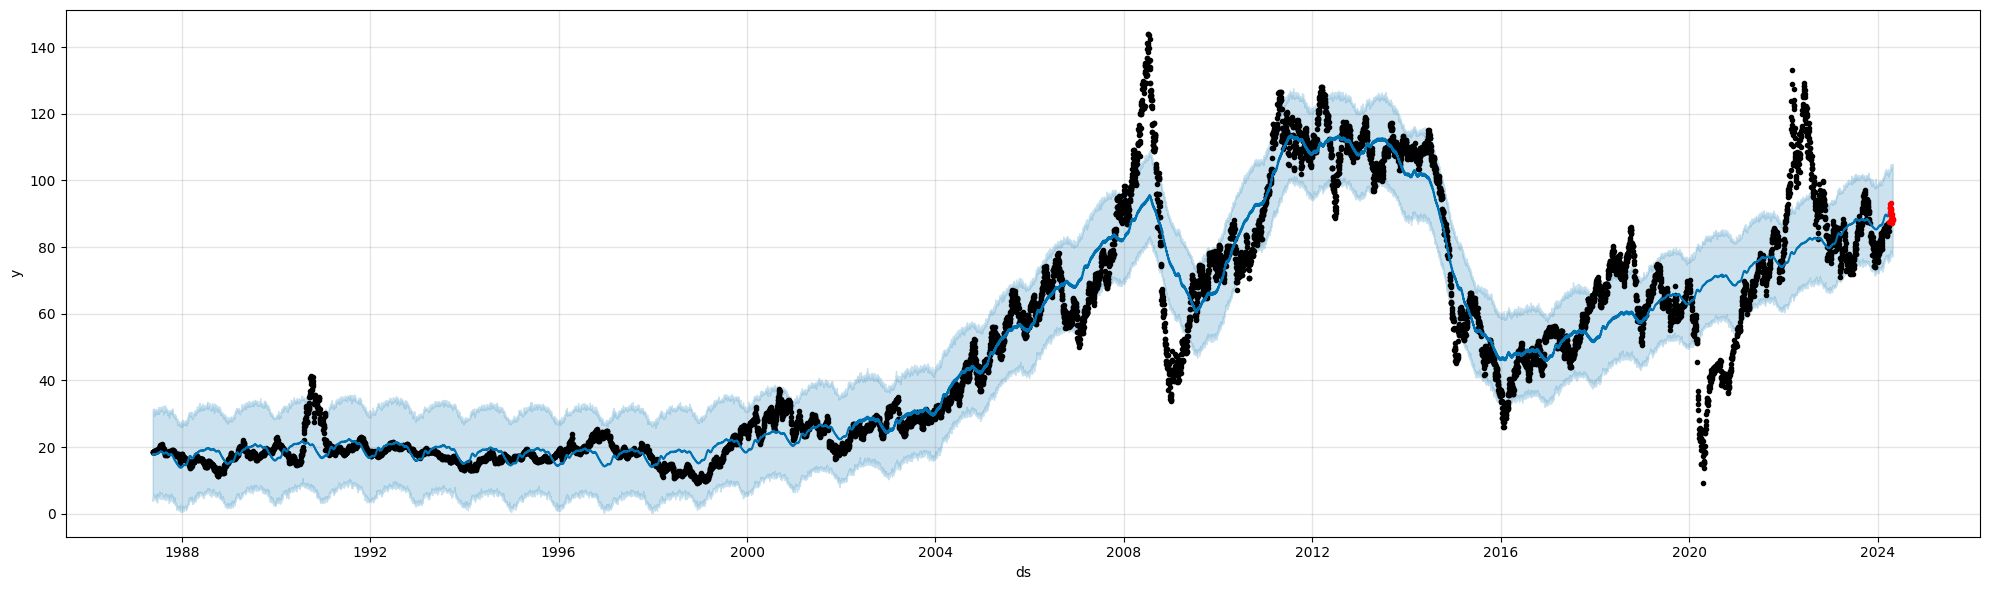

In [61]:
# Fit do modelo
model_prophet_v1 = Prophet()
model_prophet_v1.fit(df_train)

# Criando Dataframe com a
future = model_prophet_v1.make_future_dataframe(periods=qtd_dias_prev)
# future = future[future['ds'].dt.dayofweek <= 4] # removendo sábado e domingo
# future.tail()

# Previsões com o modelo
forecast_pv1 = model_prophet_v1.predict(future)
# forecast_pv1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# Plot da previsão
model_prophet_v1.plot(forecast_pv1, figsize=(20,6));
plt.plot(df_test['ds'], df_test['y'], '.r', )

# Calculando métricas
forecast_test_df = joinTestPred(df_test=df_test, df_pred=forecast_pv1)
evaluation_df = evaluation_ts(model_name='prophet', y_true=forecast_test_df.y.values, y_pred=forecast_test_df.yhat.values)
print(evaluation_df)


# # Adicionando métricas
# evaluation_df = pd.concat([evaluation_df, eval_df], axis=0)